In [80]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Outline
* Preprocess 
    * Get rid of missing values 
    * Get rid of superfluous features i.e. ID 
    * Normalize ? 
* Do exploratory data analysis
* Use feature selection algorithms
    * All features (no selection)
    * Variance score
    * Recursive feature elimination
    * Boruta 
    * Filter 
    * Manually selected using info from EDA 

* Cross validation
* Output results to dataframe; 1 dataframe for each model type or 1 exhaustive dataframe? 





In [62]:
# preprocess and clean data
df = pd.read_csv("auto_1993_adj.csv")
df = df.drop("ID", axis =1)
df = df.dropna()

X = df.drop('mpg', axis = 1)
print(X.shape)
y = df['mpg']

#adding ratio because of high correlation
X['displacement/cylinders'] = X['displacement']/X['cylinders']

#normalizing values
scaler = preprocessing.MinMaxScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X), columns = [f"{x}_norm" for x in X.columns])

#reset indices for concatenation
X.reset_index(drop = True, inplace= True)
X_norm.reset_index(drop = True, inplace= True)
#concatenating normalized values to features
X = pd.concat([X, X_norm], axis = 1)

#dropping normalized year and origin because they went to 0 bc discrete features 
X = X.drop(['model_year_norm', 'origin_norm'], axis = 1)
#log transformations of skewed distribution
X[['log_weight', 'log_displacement', 'log_horsepower']] = np.log(X[['weight', 'displacement', 'horsepower']])
print(X.shape)
print(y.shape)
X.head()

(392, 7)
(392, 17)
(392,)


,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,displacement/cylinders,displacement_norm,cylinders_norm,horsepower_norm,weight_norm,acceleration_norm,displacement/cylinders_norm,log_weight,log_displacement,log_horsepower
0,307.0,8,130.0,3504,12.0,70,1,38.375,0.617571,1.0,0.456522,0.536150,0.238095,0.536050,8.161660,5.726848,4.867534
1,350.0,8,165.0,3693,11.5,70,1,43.750,0.728682,1.0,0.646739,0.589736,0.208333,0.670846,8.214194,5.857933,5.105945
2,318.0,8,150.0,3436,11.0,70,1,39.750,0.645995,1.0,0.565217,0.516870,0.178571,0.570533,8.142063,5.762051,5.010635
3,304.0,8,150.0,3433,12.0,70,1,38.000,0.609819,1.0,0.565217,0.516019,0.238095,0.526646,8.141190,5.717028,5.010635
4,302.0,8,140.0,3449,10.5,70,1,37.750,0.604651,1.0,0.510870,0.520556,0.148810,0.520376,8.145840,5.710427,4.941642


(398, 17)
(392,)


<Axes: >

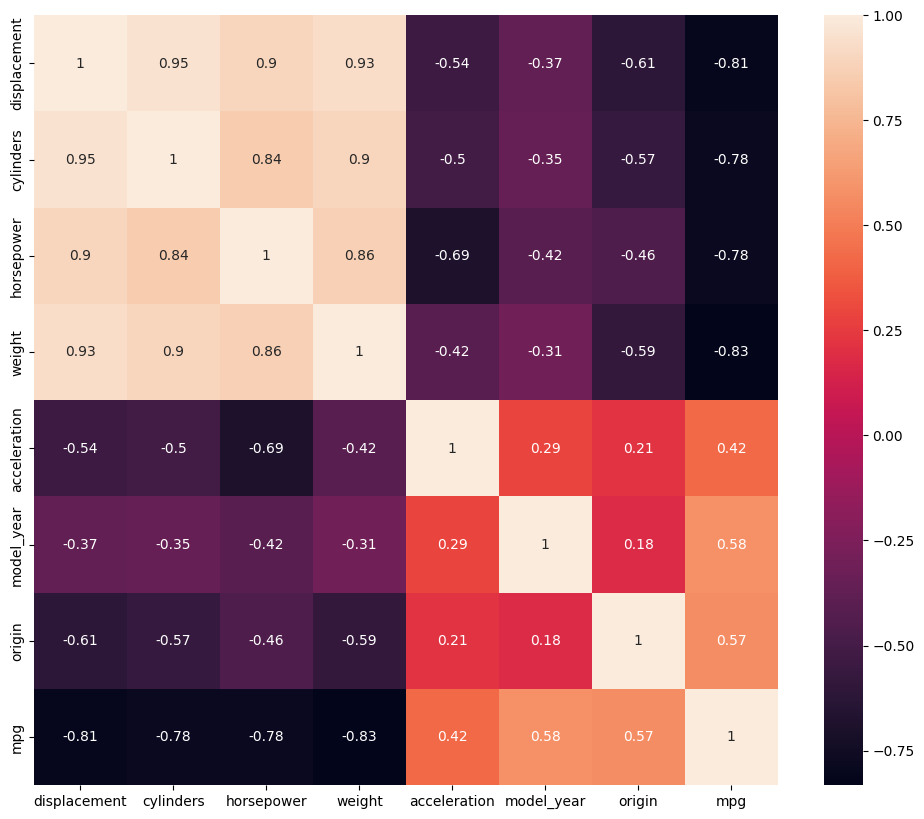

In [14]:
# data exploration
# correlation matrix
test = X.copy()
test['mpg'] = y
corr_matrix = test.corr()

plt.figure(figsize = (12,10))
sns.heatmap(corr_matrix, annot=True)
#strong correlation was displacement, cylinders, weight, horsepower


In [15]:
# mutual information
mi = mutual_info_regression(X, y)
features = X.columns
for i in range(len(mi)):
    print(f"{features[i]}: {mi[i]}")

#again displacement, cylinders, horsepower, weight are strongest

displacement: 0.7841663507407204
cylinders: 0.6103922414895719
horsepower: 0.7221703338078775
weight: 0.7864888570029369
acceleration: 0.19829137644016193
model_year: 0.3444158642926727
origin: 0.2486819628792183


array([[<Axes: title={'center': 'displacement'}>,
        <Axes: title={'center': 'cylinders'}>,
        <Axes: title={'center': 'horsepower'}>],
       [<Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'acceleration'}>,
        <Axes: title={'center': 'model_year'}>],
       [<Axes: title={'center': 'origin'}>,
        <Axes: title={'center': 'mpg'}>, <Axes: >]], dtype=object)

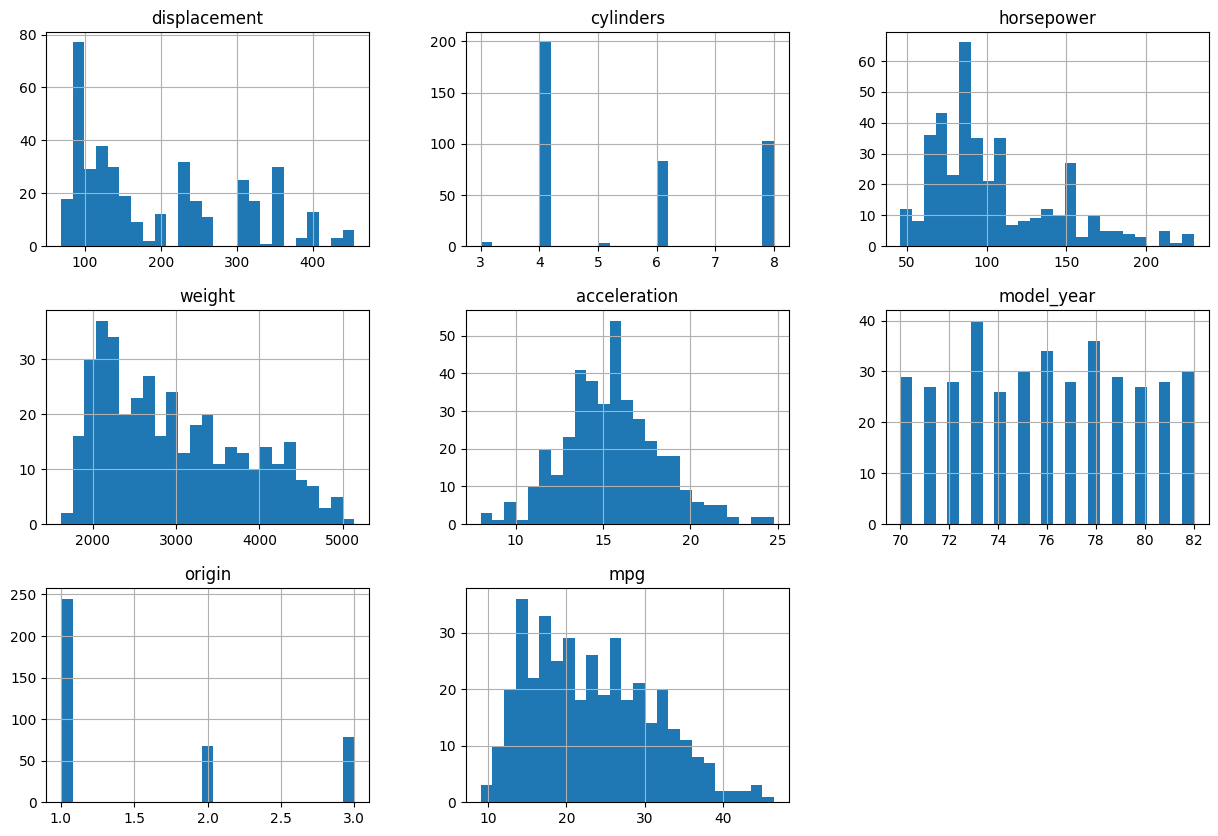

In [16]:
# histogram
test.hist(bins = 25, figsize = (15,10))


In [126]:
# feature selection
og_features = list(df.drop('mpg',axis =1).columns)
normalized = list(X_norm.drop(['model_year_norm', 'origin_norm'], axis = 1).columns)

#kbest filtering
selector = SelectKBest(mutual_info_regression, k = 6)
selector.fit(X, y)
kbest = list(X.columns[list(selector.get_support())])

#kbest with diff k 
selector = SelectKBest(mutual_info_regression, k = 10)
selector.fit(X, y)
kbest_more = list(X.columns[list(selector.get_support())])

selector = SelectKBest(mutual_info_regression, k = 3)
selector.fit(X, y)
kbest_less = list(X.columns[list(selector.get_support())])

manual = og_features[:4]
#return list of features to use
feature_combos = [og_features, normalized, kbest, kbest_more, kbest_less, manual]
feature_combos_name = ["og_features", "normalized", "kbest", "kbest_more", "kbest_less", "manual"]
print(feature_combos)


[['displacement', 'cylinders', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin'], ['displacement_norm', 'cylinders_norm', 'horsepower_norm', 'weight_norm', 'acceleration_norm', 'displacement/cylinders_norm'], ['displacement', 'weight', 'displacement_norm', 'weight_norm', 'log_weight', 'log_displacement'], ['displacement', 'horsepower', 'weight', 'displacement_norm', 'horsepower_norm', 'weight_norm', 'displacement/cylinders_norm', 'log_weight', 'log_displacement', 'log_horsepower'], ['weight', 'weight_norm', 'log_displacement'], ['displacement', 'cylinders', 'horsepower', 'weight']]


In [127]:
# create training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 99)
print(y_train.shape)


(294,)


In [128]:
# run models
model_stats = pd.DataFrame(columns = ['model', 'features', 'mse', 'percent error', 'r2'])
models = [KNeighborsRegressor(), SVR(), Ridge()]

#run each model for each feature combo, for a total of 18 
for m in models:
    for i in range(len(feature_combos)):
        f = feature_combos[i]
        model = m    #can tweak hyperparameters if needed
        X_temp = X_train[f] #only get desired features
        model.fit(X_temp, y_train)
        pred = model.predict(X_test[f])
        mse = mean_squared_error(y_test, pred)
        percent_e = mean_absolute_percentage_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        model_stats.loc[len(model_stats.index)] = [str(m), feature_combos_name[i], mse, percent_e, r2]

        
    

In [129]:
model_stats.head(20)

,model,features,mse,percent error,r2
0,KNeighborsRegressor(),og_features,14.336224,0.110090,0.763996
1,KNeighborsRegressor(),normalized,16.742073,0.124883,0.724391
2,KNeighborsRegressor(),kbest,15.994482,0.118544,0.736698
3,KNeighborsRegressor(),kbest_more,14.336224,0.110090,0.763996
4,KNeighborsRegressor(),kbest_less,18.481008,0.130188,0.695765
5,KNeighborsRegressor(),manual,14.336224,0.110090,0.763996
6,SVR(),og_features,20.238105,0.127958,0.666839
7,SVR(),normalized,19.492965,0.121506,0.679106
8,SVR(),kbest,20.241491,0.128001,0.666783
9,SVR(),kbest_more,20.482732,0.128149,0.662812
